# Day 8 Analysis

For Day 8, let's look at the relationship between target share and fantasy points for receivers and see who might be due for a positive or negative regression to the mean.

## Set Up

In [155]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
from os import path
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create database connection
conn = sqlite3.connect('../data/db/database.db')

## Target Share vs. Fantasy Points
Let's get target share and fantasy points scored for receivers going back to 1999. We should see a positive relationship – as target share increase, fantasy points scored should increase as well.

In [114]:
query = """
SELECT
    player_id,
    player_display_name AS player_name,
    season,
    week,
    receptions,
    targets,
    (1.0 * receptions/targets) AS tgt_conv,
    receiving_yards AS yds,
    receiving_tds AS tds,
    receiving_air_yards AS air_yds,
    receiving_yards_after_catch AS yac,
    ROUND(target_share,3) AS tgt_share,
    ROUND(air_yards_share,3) AS air_yds_share,
    ROUND(fantasy_points,2) AS fantasy_pts,
    ROUND(fantasy_points_ppr,2) AS fantasy_pts_ppr
FROM weekly 
WHERE position = 'WR'
    AND season_type = 'REG'
"""

df_all = pd.read_sql(query, conn)

print(df_all.shape)
df_all.head()

(43959, 15)


,player_id,player_name,season,week,receptions,targets,tgt_conv,yds,tds,air_yds,yac,tgt_share,air_yds_share,fantasy_pts,fantasy_pts_ppr
0,00-0000145,Derrick Alexander,1999,1,6,10,0.600000,154.0,1,0.0,0.0,0.244,0.0,21.4,27.4
1,00-0000145,Derrick Alexander,1999,2,6,7,0.857143,117.0,0,0.0,0.0,0.412,0.0,11.7,17.7
2,00-0000145,Derrick Alexander,1999,3,3,6,0.500000,69.0,0,0.0,0.0,0.207,0.0,6.9,9.9
3,00-0000145,Derrick Alexander,1999,4,1,7,0.142857,14.0,0,0.0,0.0,0.194,0.0,1.4,2.4
4,00-0000145,Derrick Alexander,1999,5,2,5,0.400000,25.0,0,0.0,0.0,0.200,0.0,2.5,4.5


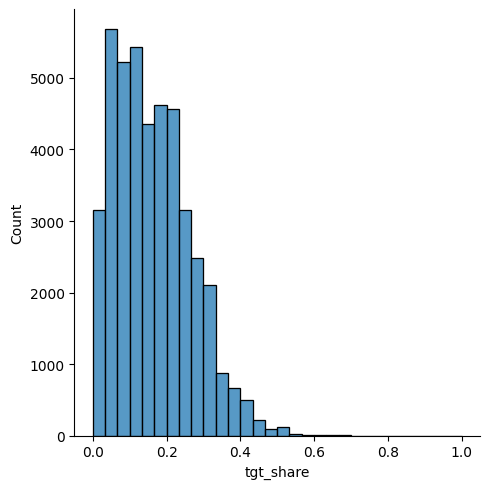

In [96]:
# Check distribution
sns.displot(
    x="tgt_share",
    data=df_all,
    kind="hist",
    bins = 30
)

In [92]:
df_all[df_all['tgt_share'] == 0]

,player_id,player_name,season,week,receptions,targets,yds,tds,air_yds,yac,tgt_share,air_yds_share,fantasy_pts,fantasy_pts_ppr
10447,00-0022124,Taylor Jacobs,2004,3,0,0,0.0,0,0.0,0.0,0.0,0.0,2.0,2.0
10638,00-0022889,Reggie Williams,2004,6,0,0,0.0,0,0.0,0.0,0.0,0.0,2.0,2.0
24843,00-0029702,Juron Criner,2012,9,0,0,0.0,0,0.0,0.0,0.0,0.0,2.0,2.0
40450,00-0036182,Nick Westbrook-Ikhine,2020,6,0,0,0.0,0,0.0,0.0,0.0,0.0,2.0,2.0


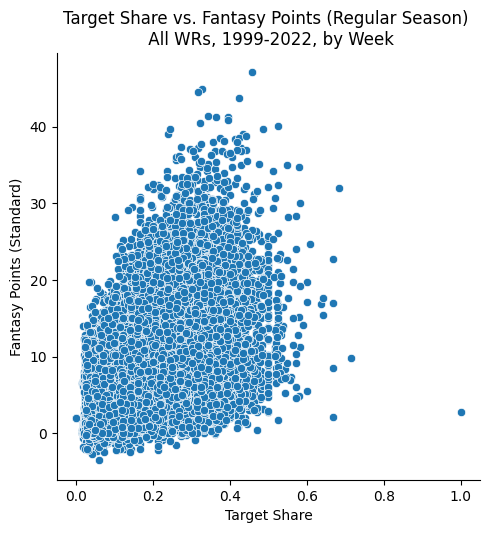

In [148]:
g = sns.relplot(
    x="tgt_share",
    y="fantasy_pts",
    data=df_all
)

g.set(
    xlabel="Target Share", 
    ylabel="Fantasy Points (Standard)",
    title="Target Share vs. Fantasy Points (Regular Season) \n All WRs, 1999-2022, by Week"
)

In [150]:
print(f"Correlation Coefficient: {df_all['tgt_share'].corr(df_all['fantasy_pts'])}")

Correlation Coefficient: 0.606503039715833


I'll group by player to smooth out the variance and verify that the relationship holds over the course of a season and a player's career

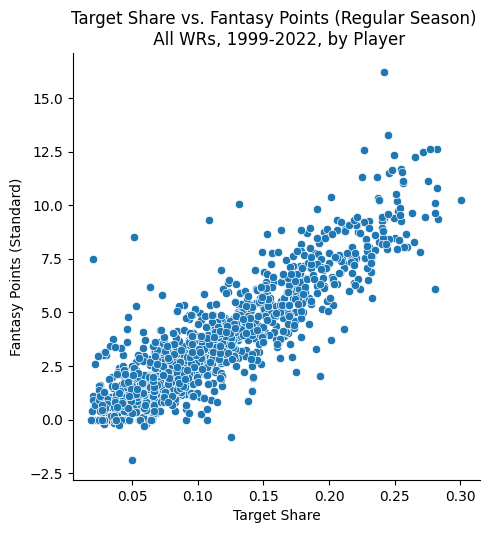

In [189]:
# Aggregate
df_avg = df_all.groupby(['player_id', 'player_name']).mean().reset_index()

# Plot
g = sns.relplot(
    x="tgt_share",
    y="fantasy_pts",
    data=df_avg
)

g.set(
    xlabel="Target Share", 
    ylabel="Fantasy Points (Standard)",
    title="Target Share vs. Fantasy Points (Regular Season) \n All WRs, 1999-2022, by Player"
)

In [190]:
print(f"Correlation Coefficient: {round(df_avg['tgt_share'].corr(df_avg['fantasy_pts']),2)}")

Correlation Coefficient: 0.89


A correlation coefficient of 0.89 shows a very strong positive correlation between a player's average air yards and average fantasy points over their career.

In [193]:
# Look at the top 5 receivers by average fantasy points over their career
col_order = [
    'player_name', 'receptions', 'targets', 'yds', 'tds',
    'air_yds', 'yac', 'tgt_share', 'air_yds_share', 'fantasy_pts', 'fantasy_pts_ppr']

df_avg = df_avg.sort_values('fantasy_pts', ascending=False)[col_order].reset_index(drop=True)

df_avg.head(5)


,player_name,receptions,targets,yds,tds,air_yds,yac,tgt_share,air_yds_share,fantasy_pts,fantasy_pts_ppr
0,Kristian Wilkerson,4.000000,8.000000,42.000000,2.000000,132.000000,5.000000,0.242000,0.534000,16.200000,20.200000
1,Ja'Marr Chase,5.333333,8.416667,85.833333,0.791667,95.041667,38.500000,0.244792,0.369208,13.262500,18.595833
2,Cory Ross,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,13.200000,13.200000
3,Justin Jefferson,6.200000,9.075000,94.200000,0.475000,101.925000,31.675000,0.276975,0.424375,12.625500,18.825500
4,Marvin Harrison,6.191781,8.698630,82.664384,0.732877,12.191781,3.609589,0.282356,0.065123,12.608904,18.800685


In [194]:
# Now order by target share
df_avg.sort_values('tgt_share', ascending=False).head()

,player_name,receptions,targets,yds,tds,air_yds,yac,tgt_share,air_yds_share,fantasy_pts,fantasy_pts_ppr
23,Jimmy Smith,5.579439,8.971963,77.093458,0.420561,0.000000,0.000000,0.300869,0.000000,10.231776,15.811215
39,Rod Smith,5.336000,8.112000,68.464000,0.376000,2.936000,1.144000,0.282808,0.026584,9.355840,14.691840
4,Marvin Harrison,6.191781,8.698630,82.664384,0.732877,12.191781,3.609589,0.282356,0.065123,12.608904,18.800685
18,DeAndre Hopkins,5.876812,9.413043,78.572464,0.500000,111.927536,20.992754,0.282022,0.385935,10.809710,16.686522
212,Drake London,3.750000,6.125000,43.250000,0.250000,61.500000,13.750000,0.280500,0.288250,6.075000,9.825000


## Air Yards vs. Fantasy Points: 2022

In [196]:
# Get the top 10 WRs by average fantasy points for the 2022 season
f_2022 = df_all['season'] == 2022

df_2022 = df_all[f_2022].groupby('player_id').mean()

df_2022 = df_2022.sort_values('fantasy_pts', ascending=False) \
    .reset_index() \
    .merge(
        df_all[['player_id','player_name']].drop_duplicates(), 
        how='left'
    )[col_order]

print(df_2022.shape)
df_2022.head(10)

(198, 11)


,player_name,receptions,targets,yds,tds,air_yds,yac,tgt_share,air_yds_share,fantasy_pts,fantasy_pts_ppr
0,Stefon Diggs,7.857143,10.428571,109.142857,1.000000,110.285714,35.714286,0.287429,0.369143,16.914286,24.771429
1,DeAndre Hopkins,11.000000,13.500000,131.000000,0.500000,146.500000,16.000000,0.392500,0.584500,16.100000,27.100000
2,Cooper Kupp,9.142857,12.000000,98.000000,0.714286,88.714286,48.857143,0.324714,0.413286,15.385714,24.528571
3,Tyreek Hill,8.625000,11.500000,120.125000,0.250000,132.375000,37.250000,0.321375,0.384500,13.825000,22.450000
4,Justin Jefferson,7.428571,10.142857,107.428571,0.285714,82.285714,47.428571,0.290286,0.416000,13.774286,21.202857
5,A.J. Brown,5.571429,9.142857,94.142857,0.714286,98.571429,35.428571,0.318429,0.471286,13.700000,19.271429
6,Ja'Marr Chase,6.714286,10.571429,86.428571,0.857143,94.857143,39.000000,0.275143,0.371000,13.528571,20.242857
7,Jaylen Waddle,5.250000,7.875000,90.875000,0.625000,82.625000,35.250000,0.216875,0.267000,12.800000,18.050000
8,Michael Thomas,5.333333,7.333333,57.000000,1.000000,79.000000,7.000000,0.201000,0.195333,11.700000,17.033333
9,Davante Adams,5.428571,9.714286,73.142857,0.714286,109.857143,25.000000,0.296429,0.396714,11.585714,17.014286


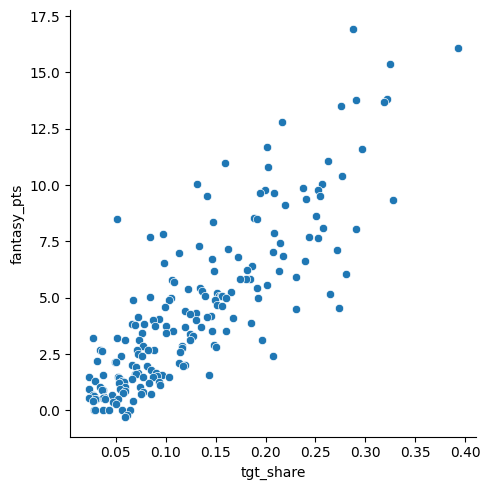

In [181]:
sns.relplot(
    x="tgt_share",
    y="fantasy_pts",
    data=df_2022
)

In [197]:
print(f"Correlation Coefficient: {round(df_2022['tgt_share'].corr(df_2022['fantasy_pts']),2)}")

Correlation Coefficient: 0.84


As expected the relationship between target share and fantasy points scored still holds true for 2022

In [199]:
col_order = ['player_name', 'tgt_share', 'fantasy_pts', 'fantasy_pts_ppr']

df_2022.sort_values('tgt_share', ascending=False)[col_order].head(10).round(3)

,player_name,tgt_share,fantasy_pts,fantasy_pts_ppr
1,DeAndre Hopkins,0.392,16.100,27.100
24,CeeDee Lamb,0.328,9.350,14.600
2,Cooper Kupp,0.325,15.386,24.529
3,Tyreek Hill,0.321,13.825,22.450
5,A.J. Brown,0.318,13.700,19.271
9,Davante Adams,0.296,11.586,17.014
32,D.J. Moore,0.290,8.050,12.175
4,Justin Jefferson,0.290,13.774,21.203
0,Stefon Diggs,0.287,16.914,24.771
53,Drake London,0.280,6.075,9.825


CeeDee Lamb stands out here. He is 2nd in target share but only 24th in fantasy points scored. D.J. Moore and Drake London also stand out for similar reasons.

Given that the correlation between target share and fantasy points is so string, let's go a step further and use linear regression to get an idea of expected average fantasy points given target share. With this we can see how much each player is under or over-performing.

## Use Linear Regression to find under and over-performers through Week 8

In [200]:
# Will first need to remove NULL values to fit a regression line to the data
df_all[['tgt_share','fantasy_pts']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43959 entries, 0 to 43958
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   tgt_share    43278 non-null  float64
 1   fantasy_pts  43959 non-null  float64
dtypes: float64(2)
memory usage: 687.0 KB


In [201]:
# Drop null values
df_all_no_null = df_all.dropna(subset=['tgt_share', 'fantasy_pts'])

fit = np.polyfit(
    x=df_all_no_null['tgt_share'], 
    y=df_all_no_null['fantasy_pts'], 
    deg=1)

lin_func_fpts = np.poly1d(fit)

In [203]:
summary_2022 = df_2022.sort_values('tgt_share', ascending=False)[col_order]

summary_2022['expected_fantasy_pts'] = lin_func_fpts(summary_2022['tgt_share'])
summary_2022['perf'] = summary_2022['fantasy_pts'] - summary_2022['expected_fantasy_pts']

summary_2022.head(10).round(3)

,player_name,tgt_share,fantasy_pts,fantasy_pts_ppr,expected_fantasy_pts,perf
1,DeAndre Hopkins,0.392,16.100,27.100,13.943,2.157
24,CeeDee Lamb,0.328,9.350,14.600,11.659,-2.309
2,Cooper Kupp,0.325,15.386,24.529,11.552,3.833
3,Tyreek Hill,0.321,13.825,22.450,11.435,2.390
5,A.J. Brown,0.318,13.700,19.271,11.331,2.369
9,Davante Adams,0.296,11.586,17.014,10.555,1.031
32,D.J. Moore,0.290,8.050,12.175,10.346,-2.296
4,Justin Jefferson,0.290,13.774,21.203,10.338,3.436
0,Stefon Diggs,0.287,16.914,24.771,10.237,6.677
53,Drake London,0.280,6.075,9.825,9.993,-3.918


Based on this CeeDee Lamb should be scoring about 2.3 more points per game on average!

In [205]:
# Sort by the difference between actual points and expected points to get the true "regression to the mean" candidates
summary_2022.sort_values('perf').head(10).round(3)

,player_name,tgt_share,fantasy_pts,fantasy_pts_ppr,expected_fantasy_pts,perf
82,Darnell Mooney,0.273,4.550,7.675,9.737,-5.187
129,Dezmon Patmon,0.207,2.400,4.400,7.401,-5.001
67,Diontae Johnson,0.265,5.175,10.550,9.437,-4.262
53,Drake London,0.280,6.075,9.825,9.993,-3.918
113,Equanimeous St. Brown,0.196,3.125,4.625,7.018,-3.893
83,Robert Woods,0.231,4.514,7.657,8.242,-3.728
146,Marcus Johnson,0.143,1.575,3.075,5.143,-3.568
94,Michael Gallup,0.186,3.900,6.300,6.646,-2.746
118,Richie James,0.151,2.814,5.671,5.420,-2.606
41,Sterling Shepard,0.272,7.133,11.467,9.693,-2.560


Darnell Mooney is the standout here. With almost 27% of his team's target share in 2022 he's scoring about 5pts less per game than he "should be" based on the observed relationship between target share and fantasy points. 